### Import libraries 

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime as dt 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from xgboost import XGBClassifier 
from xgboost import cv

import sys 

print(dt.datetime.now(), 'python version:')
print(sys.version)
print(dt.datetime.now(), 'pandas version:', pd.__version__)

2019-03-08 23:03:29.901141 python version:
3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]
2019-03-08 23:03:29.901451 pandas version: 0.23.4


### Read data

In [3]:
print(dt.datetime.now(), 'start reading data...')

dirc = '../input/'

train = pd.read_csv(dirc + 'train.csv.zip', compression='zip')
test = pd.read_csv(dirc + 'test.csv.zip', compression='zip')
submission = pd.read_csv(dirc + 'sample_submission.csv.zip', compression='zip')

print(dt.datetime.now(), 'finish reading data')

test.drop('ID_code', axis=1, inplace=True) 

2019-03-08 23:03:31.501649 start reading data...
2019-03-08 23:03:53.496686 finish reading data


### Cross validation test

In [34]:
train_x, val_x, train_y, val_y = \
    train_test_split(train.drop(['ID_code', 'target'], axis=1), train.target, test_size = 0.10) 

print(dt.datetime.now(), 'finish splitting data')

print(dt.datetime.now(), 'start training...')

model_cv = XGBClassifier(n_estimators=2000, n_jobs=16, learning_rate=0.05) 
cvs = cross_val_score(model_cv, train_x, train_y, 
                      cv=4, scoring='roc_auc', verbose=2, n_jobs=4, 
                      fit_params={
                          'verbose': True, 'eval_set': [(val_x, val_y)], 'eval_metric': 'auc', 
                          'early_stopping_rounds': 20
                      })

print(cvs, 'mean =', cvs.mean())
print(dt.datetime.now(), 'finish training') 

2019-03-08 22:38:20.766268 finish splitting data
2019-03-08 22:38:20.766509 start training...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[0.88630508 0.89551402 0.89299577 0.89613434] mean = 0.8927373027309772
2019-03-08 22:46:15.231546 finish training


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.9min finished


### Regular train_test_split xgboost training

In [4]:
train_x, val_x, train_y, val_y = \
    train_test_split(train.drop(['ID_code', 'target'], axis=1), train.target, test_size = 0.10) 

print(dt.datetime.now(), 'finish splitting data')

print(dt.datetime.now(), 'start training...')

model = XGBClassifier(n_estimators=2000, n_jobs=32, learning_rate=0.05) 
model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
          verbose=False,
          eval_metric='auc', early_stopping_rounds=20)

pred = model.predict_proba(val_x)[:, 1]
print('roc_auc_score:', roc_auc_score(val_y, pred))

# sns.distplot(pred - val_y) 

print(dt.datetime.now(), 'finish training') 

2019-03-08 23:03:54.171494 finish splitting data
2019-03-08 23:03:54.171700 start training...
roc_auc_score: 0.9007538640204167
2019-03-08 23:08:50.250454 finish training


### Eval function versus training steps

In [ ]:
eval_auc = model.evals_result()['validation_0']['auc']

plt.figure(figsize=(10, 6.18))
plt.xlabel('training step')
plt.ylabel('auc')
sns.lineplot(x = range(len(eval_auc)), y = eval_auc)

### Receiver operating characteristic curve

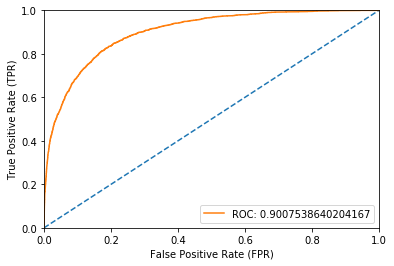

In [53]:
fpr, tpr, thresholds = roc_curve(val_y, pred)
score = roc_auc_score(val_y, pred)

plt.figure()
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(fpr, fpr, linestyle='--')
plt.plot(fpr, tpr, label='ROC: '+str(score))
plt.legend()
plt.show()

### Submit 

In [52]:
submission['target'] = model.predict_proba(test)[:, 1]
submission.to_csv('submission.csv', index=False)